## Earthquake Magnitude Scale 

[https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/](https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/)

| Magnitude     | Earthquake Effects                                                               | Estimated Number Each Year |
|---------------|----------------------------------------------------------------------------------|-----------------------------|
| 2.5 or less   | Usually not felt, but can be recorded by seismograph.                             | Millions                    |
| 2.5 to 5.4    | Often felt, but only causes minor damage.                                        | 500,000                     |
| 5.5 to 6.0    | Slight damage to buildings and other structures.                                 | 350                         |
| 6.1 to 6.9    | May cause a lot of damage in very populated areas.                               | 100                         |
| 7.0 to 7.9    | Major earthquake. Serious damage.                                                | 10-15                       |
| 8.0 or greater| Great earthquake. Can totally destroy communities near the epicenter.           | One every year or two       |



## Fault Lines

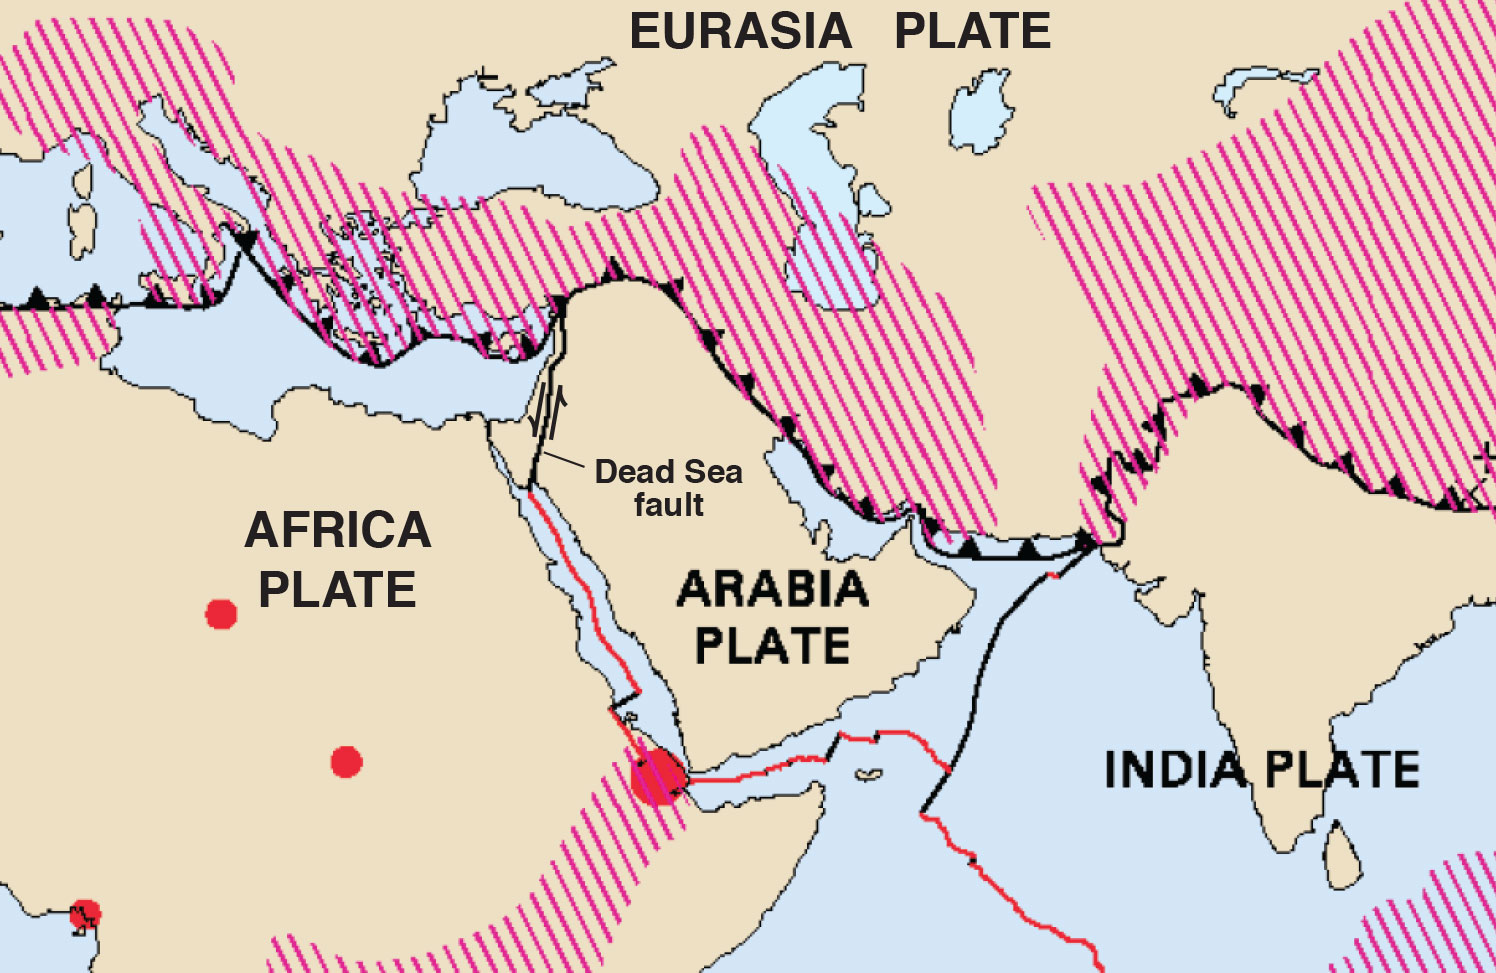

In [1]:
from IPython.display import Image

Image(filename='middle_east_faultlines.jpg')

## Earthquake Data

[https://earthquake.usgs.gov/earthquakes/search/](https://earthquake.usgs.gov/earthquakes/search/)

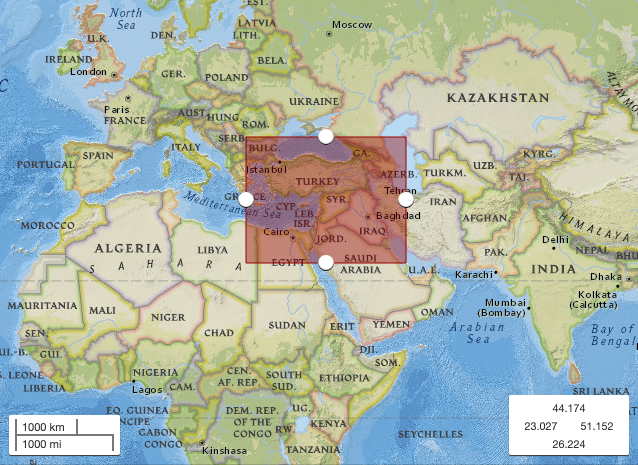

In [4]:
from IPython.display import Image

Image(filename='initial_map.png')

In [3]:
from requests import get

url = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2023-03-12%2000%3A00%3A00&endtime=2023-04-12%2023%3A59%3A59&maxlatitude=44.3&minlatitude=27.79&maxlongitude=51.328&minlongitude=21.973&minmagnitude=2.5&orderby=time"
response = get(url)

if response.status_code == 200:
    response = response.json()
    features = response['features']
    print("\nSuccess!\n")
    print(f'{len(features)} earthquakes found.\n')


Success!

59 earthquakes found.



In [4]:
from datetime import datetime
from urllib import parse
from tabulate import tabulate

urlParams = dict({
    'startTime': 'starttime',
    'endTime': 'endtime',
    'maxLatitude': 'maxlatitude',
    'minLatitude': 'minlatitude',
    'maxLongitude': 'maxlongitude',
    'minLongitude': 'minlongitude',
    'minMagnitude': 'minmagnitude',
    'orderBy': 'orderby'
})

def parse_url_segment(url, delimiter):
    return parse.unquote(url.split(delimiter)[1].split("&")[0])


def parse_url(url):
    obj = dict(urlParams)

    for key in obj:
        obj[key] = parse_url_segment(url, obj[key] + "=")

        if (key == 'startTime' or key == 'endTime'):
            obj[key] = datetime.strptime(obj[key], "%Y-%m-%d %H:%M:%S")

        if (key == 'maxLatitude' or key == 'minLatitude' or key == 'maxLongitude' or key == 'minLongitude' or key == 'minMagnitude'):
            obj[key] = float(obj[key])

    return obj

def create_table_from_params(urlParams): 
    table = []
    for key, value in urlParams.items():
        if isinstance(value, datetime):
            value = value.strftime('%Y-%m-%d %H:%M:%S')
        else:
            value = str(value)
        table.append((key, value))
    return tabulate(table, headers=['Parameter', 'Value'], tablefmt='grid')

urlParams = parse_url(url)
table = create_table_from_params(urlParams)
print(table)

+--------------+---------------------+
| Parameter    | Value               |
+==============+=====================+
| startTime    | 2023-03-12 00:00:00 |
+--------------+---------------------+
| endTime      | 2023-04-12 23:59:59 |
+--------------+---------------------+
| maxLatitude  | 44.3                |
+--------------+---------------------+
| minLatitude  | 27.79               |
+--------------+---------------------+
| maxLongitude | 51.328              |
+--------------+---------------------+
| minLongitude | 21.973              |
+--------------+---------------------+
| minMagnitude | 2.5                 |
+--------------+---------------------+
| orderBy      | time                |
+--------------+---------------------+


In [5]:
# input
YEARS_TO_COLLECT = 20
MIN_MAGNITUDE = 0
FILE_NAME = 'earthquakes' # without extension

In [6]:
from datetime import timedelta

urlParams['minMagnitude'] = MIN_MAGNITUDE
urlParams['endTime'] = datetime.now()
urlParams['startTime'] = urlParams['endTime'] - \
    timedelta(weeks=YEARS_TO_COLLECT*52)

table = create_table_from_params(urlParams)
print(table)

+--------------+---------------------+
| Parameter    | Value               |
+==============+=====================+
| startTime    | 2003-05-27 21:29:59 |
+--------------+---------------------+
| endTime      | 2023-05-02 21:29:59 |
+--------------+---------------------+
| maxLatitude  | 44.3                |
+--------------+---------------------+
| minLatitude  | 27.79               |
+--------------+---------------------+
| maxLongitude | 51.328              |
+--------------+---------------------+
| minLongitude | 21.973              |
+--------------+---------------------+
| minMagnitude | 0                   |
+--------------+---------------------+
| orderBy      | time                |
+--------------+---------------------+


In [ ]:

%matplotlib inline
import pandas as pd

df = pd.DataFrame(columns=['magnitude',
                  'time', 'latitude', 'longitude', 'depth'])


def append_earthquakes_to_dataframe(features):
    for earthquake in features:
        magnitude = earthquake['properties']['mag']
        time = earthquake['properties']['time']
        latitude = earthquake['geometry']['coordinates'][1]
        longitude = earthquake['geometry']['coordinates'][0]
        depth = earthquake['geometry']['coordinates'][2]

        df.loc[len(df)] = [magnitude, time, latitude, longitude, depth]


def get_earthquake_data(urlParams: dict[urlParams]):
    timeStep = urlParams['endTime'] - urlParams['startTime']
    stepParams = dict(urlParams)
    while True:
        stepParams['startTime'] = stepParams['endTime'] - timeStep

        url = f"https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime={stepParams['startTime']}&endtime={stepParams['endTime']}&maxlatitude={stepParams['maxLatitude']}&minlatitude={stepParams['minLatitude']}&maxlongitude={stepParams['maxLongitude']}&minlongitude={stepParams['minLongitude']}&minmagnitude={stepParams['minMagnitude']}&orderby={stepParams['orderBy']}"
        response = get(url)

        if response.status_code == 400 and "matching events exceeds search limit" in response.text:
            print('search limit reached, timestep reduced')
            timeStep = timedelta(seconds=timeStep.total_seconds() / 2)
            continue

        if response.status_code != 200:
            print("Error: ", response.status_code)
            print(response.text)
            break

        append_earthquakes_to_dataframe(response.json()['features'])

        stepParams['endTime'] = stepParams['startTime']
        if (stepParams['endTime'] < urlParams['startTime']):
            break


get_earthquake_data(urlParams)

df.to_csv(FILE_NAME + '.csv')
print(f'\n{len(df)} earthquakes successfully exported to `{FILE_NAME}`.csv.')

search limit reached, timestep reduced

35565 earthquakes successfully exported to `earthquakes`.csv.


In [3]:
IMPORT_FILE_NAME = 'earthquakes' # without extension

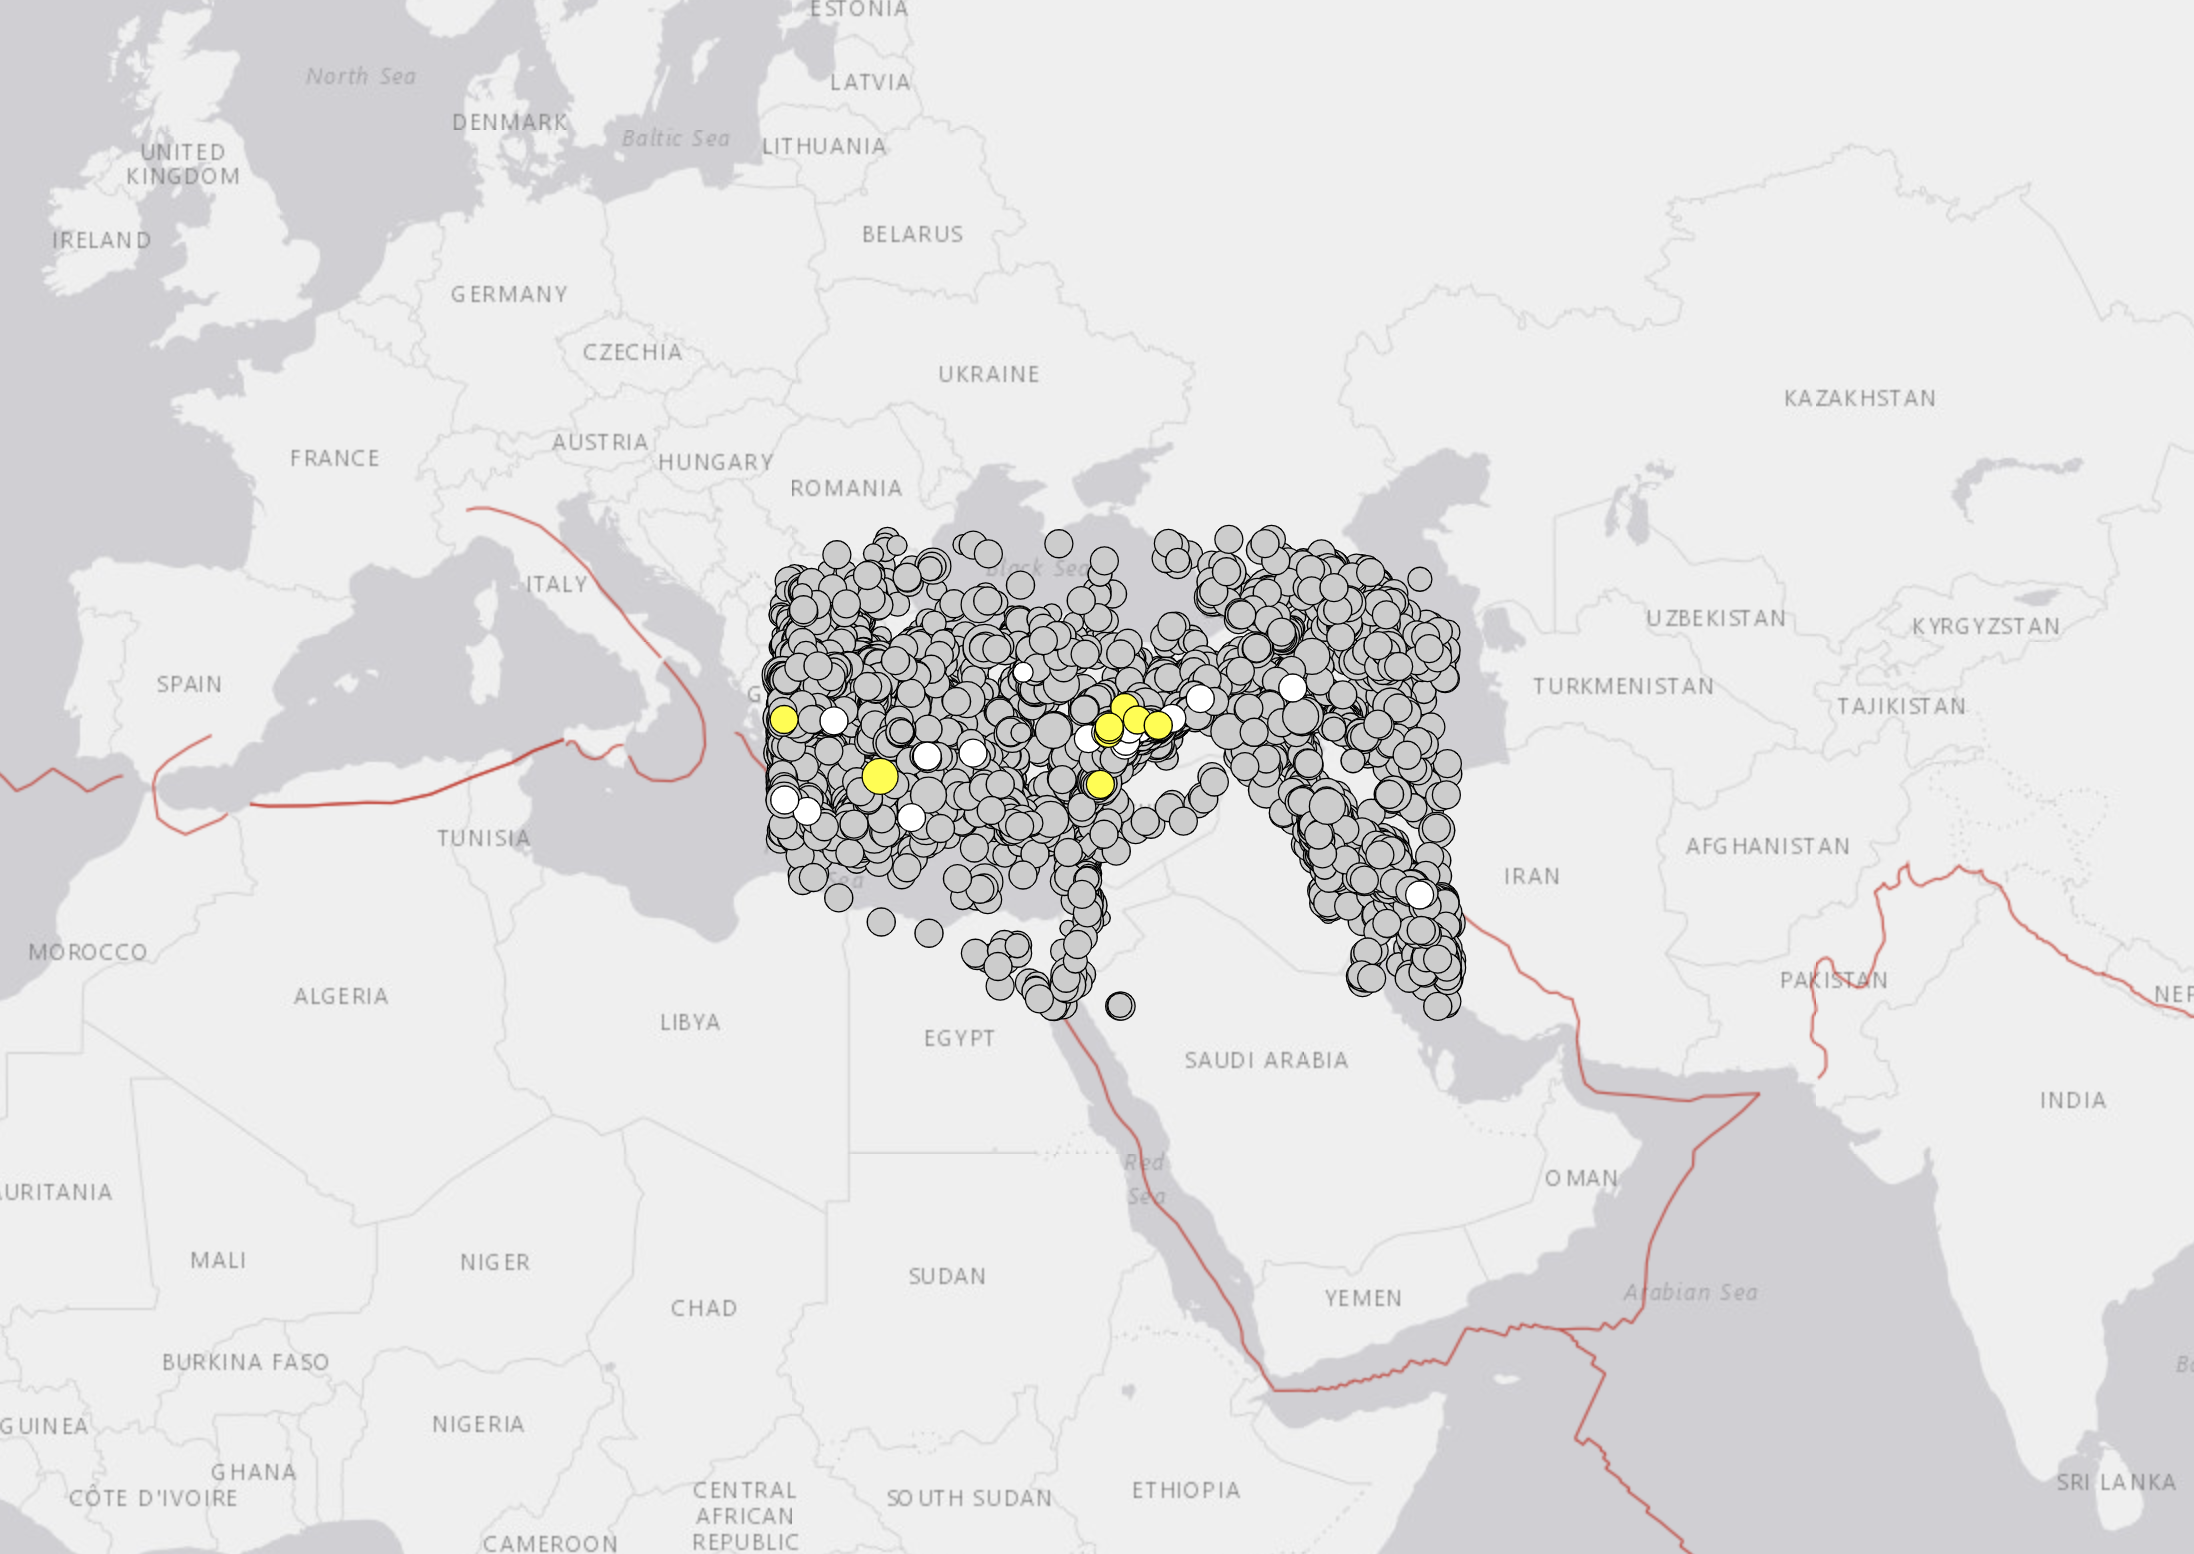

In [4]:
from IPython.display import Image
import pandas as pd

df = pd.read_csv(IMPORT_FILE_NAME + '.csv', index_col=0)

# convert time column to datetime
df['datetime'] = pd.to_datetime(df['time'], unit='ms')

Image(filename='collected_map.png')

In [5]:
# input
PROFILE_REPORT_FILENAME = 'profile_report' # don't include extension

In [6]:

import ydata_profiling as ydp

profile = ydp.ProfileReport(df)

profile.to_file(PROFILE_REPORT_FILENAME + '.html')

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_date_pandas.py:35: UserWarning: Discarding nonzero nanoseconds in conversion.
  "max": pd.Timestamp.to_pydatetime(series.max()),


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
import ydata_profiling as ydp
import pandas as pd
import math

# filter out earthquakes with magnitude less than 1 and greater than 6.2
df0 = df.loc[df['magnitude'].between(1, 6.2)].copy()

# bin the time data into bin sizes of 1 week
df0['bin'] = df0.groupby(pd.Grouper(key='datetime', freq='7D')).ngroup()

# downsample to 30% of data in each bin for all rows with a bin value less than 800
df0 = df0.groupby('bin').apply(lambda x: x.sample(frac=0.3) if x.name < 796 else x).reset_index(drop=True)

# create a position column that is a haversine distance function of the latitude and longitude columns
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    # convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # calculate the differences between the latitudes and longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # apply the Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c

    return d

df0['position'] = df0.apply(lambda row: haversine(row['latitude'], row['longitude'], 31.7683, 35.2137), axis=1)

# reprofile the data
profile = ydp.ProfileReport(df0)

profile.to_file(PROFILE_REPORT_FILENAME + '_0.html')

profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/ydata_profiling/model/pandas/describe_date_pandas.py:35: UserWarning: Discarding nonzero nanoseconds in conversion.
  "max": pd.Timestamp.to_pydatetime(series.max()),


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]